# Metodos de separación ciega de señales aplicado a videos

Se exploran los metodos:

    - ICA sobre la imagen
        
    - ICA sobre una muestra de valores de los pixeles en el video (se intentan 2 tamaños)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import itertools
import scipy.linalg 
from scipy.optimize import minimize

In [2]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)

from BSS import ICA_imagen, unmixing_error

In [3]:
from funciones_auxiliares import read_video_frames_and_format, transform_frames_2_grayscale, process_frames_video, mezclar_videos, concatenate_videos, procesar_videos_color, procesar_video_color, obtener_imagen_con_valores_video 

In [4]:
folder_videos = "../Videos_originales/"

video1_path = folder_videos + "v1.mp4"
video2_path = folder_videos + "v2.mp4"
video3_path = folder_videos + "v3.mp4"

N = 100
frame_size = (N, N)
number_of_frames = 100
number_of_frames = 603

# Leer videos

In [5]:
# read videos with same same and number of frames
video1_frames_color = read_video_frames_and_format(video1_path, size = frame_size, target_frames = number_of_frames)
video2_frames_color = read_video_frames_and_format(video2_path, size = frame_size, target_frames = number_of_frames)
video3_frames_color = read_video_frames_and_format(video3_path, size = frame_size, target_frames = number_of_frames)
# sample the video 4  (uniform distribution)
noise = np.random.randint(0, 256, video1_frames_color.shape[:-1], dtype=np.uint8)
noise_3 = np.array([noise, noise, noise])
video4_frames_color = np.transpose(noise_3, (1, 2, 3, 0))
print(f"Shape of noise video: {video4_frames_color.shape}")

Original video:
Total number of frames: 603
Frame shape: (720, 720)

New frames shape: (603, 100, 100, 3)
--------------------------------------------------
Original video:
Total number of frames: 603
Frame shape: (720, 720)

New frames shape: (603, 100, 100, 3)
--------------------------------------------------
Original video:
Total number of frames: 603
Frame shape: (720, 720)

New frames shape: (603, 100, 100, 3)
--------------------------------------------------
Shape of noise video: (603, 100, 100, 3)


In [6]:
# transform the videos to grayscale
video1_frames = transform_frames_2_grayscale(video1_frames_color)
video2_frames = transform_frames_2_grayscale(video2_frames_color)
video3_frames = transform_frames_2_grayscale(video3_frames_color)
video4_frames = transform_frames_2_grayscale(video4_frames_color)

Original shape: (603, 100, 100, 3)
Grayscale shape: (603, 100, 100)
--------------------------------------------------
Original shape: (603, 100, 100, 3)
Grayscale shape: (603, 100, 100)
--------------------------------------------------
Original shape: (603, 100, 100, 3)
Grayscale shape: (603, 100, 100)
--------------------------------------------------
Original shape: (603, 100, 100, 3)
Grayscale shape: (603, 100, 100)
--------------------------------------------------


In [7]:
# process (mean and variance)
video1_frames_processed = process_frames_video(video1_frames)
video2_frames_processed = process_frames_video(video2_frames)
video3_frames_processed = process_frames_video(video3_frames)
video4_frames_processed = process_frames_video(video4_frames)

In [8]:
# juntar distintdas versiones de los 4 videos
# cada uno es de la forma: (num_videos, num_frames_video, N, N, color_chanels)
videos_color = np.array([video1_frames_color, video2_frames_color, video3_frames_color, video4_frames_color])
videos = np.array([video1_frames, video2_frames, video3_frames, video4_frames])
videos_processed = np.array([video1_frames_processed, video2_frames_processed, video3_frames_processed, video4_frames_processed])

# ver formar
print(f"Shape videos (color): {videos_color.shape}")
print(f"Shape videos: {videos.shape}")
print(f"Shape videos (processed): {videos_processed.shape}")

Shape videos (color): (4, 603, 100, 100, 3)
Shape videos: (4, 603, 100, 100)
Shape videos (processed): (4, 603, 100, 100)


# Mix the videos

In [9]:
# delimitar matriz de mezcla
A = [[0.4, 0.65, -0.4, -0.8], [0.4, 0.4, -0.4, 0.9], [-0.4, -0.4, 0.6, 0.8], [0.7, 0.5, -0.5, -0.8]]
A = np.array(A)
A

array([[ 0.4 ,  0.65, -0.4 , -0.8 ],
       [ 0.4 ,  0.4 , -0.4 ,  0.9 ],
       [-0.4 , -0.4 ,  0.6 ,  0.8 ],
       [ 0.7 ,  0.5 , -0.5 , -0.8 ]])

In [10]:
# mezclar los videos en los distintos formatos
videos_color_mezcla = mezclar_videos(A, videos_color)
videos_mezcla = mezclar_videos(A, videos)
videos_processed_mezcla = mezclar_videos(A, videos_processed)

Shape original: (4, 603, 100, 100, 3)
Shape mixture: (4, 603, 100, 100, 3)
----------------------------------------
Shape original: (4, 603, 100, 100)
Shape mixture: (4, 603, 100, 100)
----------------------------------------
Shape original: (4, 603, 100, 100)
Shape mixture: (4, 603, 100, 100)
----------------------------------------


# Intentar estimar la matriz de mezcla


## Separar usando un solo frame

In [11]:
# obtener unos frames para hacer fca
idx_frame = 200   # funciona bien
idx_frame = 300

In [12]:
# frames con pre-procesamiento

# obtener las señales originales (solo por visualizacion)
frame_x1_processed = videos_processed[0][idx_frame]
frame_x2_processed = videos_processed[1][idx_frame]
frame_x3_processed = videos_processed[2][idx_frame]
frame_x4_processed = videos_processed[3][idx_frame]
señales_originales_x_processed = [frame_x1_processed, frame_x2_processed, frame_x3_processed, frame_x4_processed]

# obtener las señales mezcladas (para aplicar ica)
frame_y1_processed = videos_processed_mezcla[0][idx_frame]
frame_y2_processed = videos_processed_mezcla[1][idx_frame]
frame_y3_processed = videos_processed_mezcla[2][idx_frame]
frame_y4_processed = videos_processed_mezcla[3][idx_frame]
señales_y_processed = [frame_y1_processed, frame_y2_processed, frame_y3_processed, frame_y4_processed]

### ICA

In [13]:
start_time = time.time()

# ejecutar ica
ica = ICA_imagen(señales_y_processed)
ica.separar_señaes(repeticiones_optimizacion = 1, iniciar_W_ortogonal = True)
elapsed_time = time.time() - start_time

print(f"Ejecucion duro {elapsed_time} segundos")

Ejecucion duro 3.0811126232147217 segundos


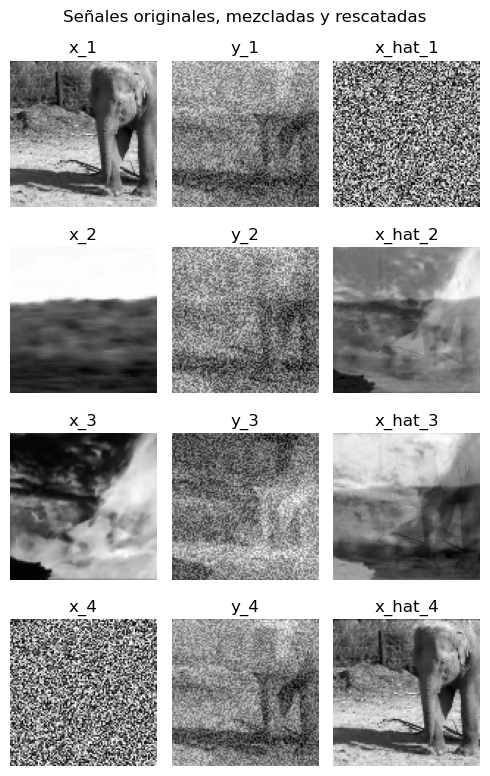

In [14]:
# ver el resultado
ica.ver(señales_x_originales = señales_originales_x_processed, figsize = (5, 8))

In [15]:
# salvar la matriz estimada por este metodo
A_hat_frame = ica.A_hat
A_hat_inv_frame = ica.A_hat_inversa

### Separar usando un solo frame sampleando distintos pixeles de todo el video


### ICA - tamaño 1

In [16]:
# dimensiones de las imagenes a crear con los valores sampleados
N_imagen = 100

In [17]:
# samplear los valores a sacar a traves del video

# ver cuantos valores se samplean
num_valores_samplear = N_imagen * N_imagen 
# primero samplear los pixeles, despues los frames, juntar todo
pixeles_sampleados = np.random.randint(0, N, size=(num_valores_samplear, 2))
frames_sampleados = np.random.randint(0, number_of_frames, size=(num_valores_samplear, 1))
indices_sampleados = np.hstack((frames_sampleados, pixeles_sampleados))
print(f"Shape indices: {indices_sampleados.shape}")

Shape indices: (10000, 3)


In [18]:
# frames con pre-procesamiento

# obtener las señales originales (solo por visualizacion)
frame_x1_processed = obtener_imagen_con_valores_video(videos_processed[0], indices_sampleados, N_imagen)
frame_x2_processed = obtener_imagen_con_valores_video(videos_processed[1], indices_sampleados, N_imagen)
frame_x3_processed = obtener_imagen_con_valores_video(videos_processed[2], indices_sampleados, N_imagen)
frame_x4_processed = obtener_imagen_con_valores_video(videos_processed[3], indices_sampleados, N_imagen)
señales_originales_x_processed = [frame_x1_processed, frame_x2_processed, frame_x3_processed, frame_x4_processed]

# obtener las señales mezcladas (para aplicar fca)
frame_y1_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[0], indices_sampleados, N_imagen)
frame_y2_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[1], indices_sampleados, N_imagen)
frame_y3_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[2], indices_sampleados, N_imagen)
frame_y4_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[3], indices_sampleados, N_imagen)
señales_y_processed = [frame_y1_processed, frame_y2_processed, frame_y3_processed, frame_y4_processed]

In [19]:
start_time = time.time()

# ejecutar ica
ica = ICA_imagen(señales_y_processed)
ica.separar_señaes(repeticiones_optimizacion = 1, iniciar_W_ortogonal = True)
elapsed_time = time.time() - start_time

print(f"Ejecucion duro {elapsed_time} segundos")

Ejecucion duro 2.952425241470337 segundos


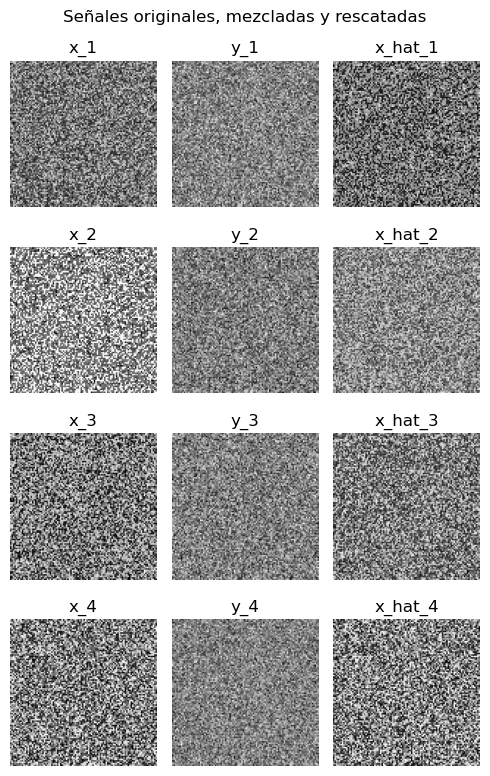

In [20]:
# ver el resultado
ica.ver(señales_x_originales = señales_originales_x_processed, figsize = (5, 8))

In [21]:
# salvar la matriz estimada por este metodo
A_hat_sample1 = ica.A_hat
A_hat_inv_sample1 = ica.A_hat_inversa

### ICA - tamaño 2

In [22]:
# dimensiones de las imagenes a crear con los valores sampleados
N_imagen = 300

In [23]:
# samplear los valores a sacar a traves del video

# ver cuantos valores se samplean
num_valores_samplear = N_imagen * N_imagen 
# primero samplear los pixeles, despues los frames, juntar todo
pixeles_sampleados = np.random.randint(0, N, size=(num_valores_samplear, 2))
frames_sampleados = np.random.randint(0, number_of_frames, size=(num_valores_samplear, 1))
indices_sampleados = np.hstack((frames_sampleados, pixeles_sampleados))
print(f"Shape indices: {indices_sampleados.shape}")

Shape indices: (90000, 3)


In [24]:
# frames con pre-procesamiento

# obtener las señales originales (solo por visualizacion)
frame_x1_processed = obtener_imagen_con_valores_video(videos_processed[0], indices_sampleados, N_imagen)
frame_x2_processed = obtener_imagen_con_valores_video(videos_processed[1], indices_sampleados, N_imagen)
frame_x3_processed = obtener_imagen_con_valores_video(videos_processed[2], indices_sampleados, N_imagen)
frame_x4_processed = obtener_imagen_con_valores_video(videos_processed[3], indices_sampleados, N_imagen)
señales_originales_x_processed = [frame_x1_processed, frame_x2_processed, frame_x3_processed, frame_x4_processed]

# obtener las señales mezcladas (para aplicar fca)
frame_y1_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[0], indices_sampleados, N_imagen)
frame_y2_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[1], indices_sampleados, N_imagen)
frame_y3_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[2], indices_sampleados, N_imagen)
frame_y4_processed = obtener_imagen_con_valores_video(videos_processed_mezcla[3], indices_sampleados, N_imagen)
señales_y_processed = [frame_y1_processed, frame_y2_processed, frame_y3_processed, frame_y4_processed]

In [25]:
start_time = time.time()

# ejecutar ica
ica = ICA_imagen(señales_y_processed)
ica.separar_señaes(repeticiones_optimizacion = 1, iniciar_W_ortogonal = True)
elapsed_time = time.time() - start_time

print(f"Ejecucion duro {elapsed_time} segundos")

Ejecucion duro 19.131637573242188 segundos


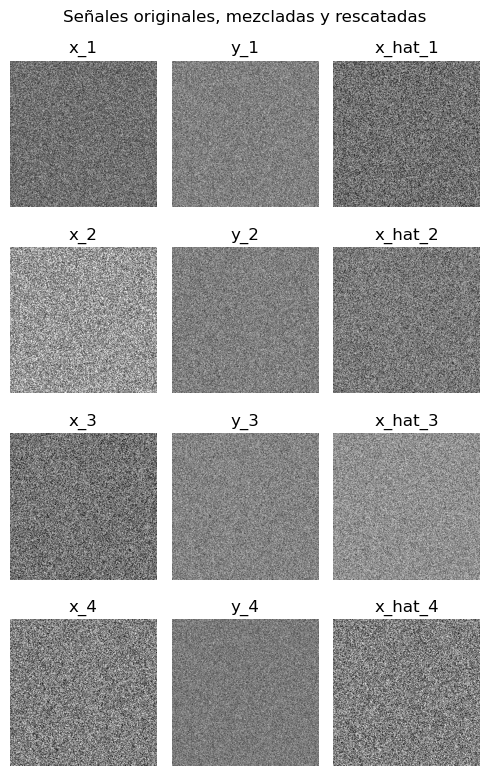

In [26]:
# ver el resultado
ica.ver(señales_x_originales = señales_originales_x_processed, figsize = (5, 8))

In [27]:
# salvar la matriz estimada por este metodo
A_hat_sample2 = ica.A_hat
A_hat_inv_sample2 = ica.A_hat_inversa

# Hacer la separacion del video a color

In [28]:
# obtener estimaciones de las señales originales
videos_color_hat_frame    = mezclar_videos(A_hat_inv_frame, videos_color_mezcla)
videos_color_hat_sample1  = mezclar_videos(A_hat_inv_sample1, videos_color_mezcla)
videos_color_hat_sample2  = mezclar_videos(A_hat_inv_sample2, videos_color_mezcla)

Shape original: (4, 603, 100, 100, 3)
Shape mixture: (4, 603, 100, 100, 3)
----------------------------------------
Shape original: (4, 603, 100, 100, 3)
Shape mixture: (4, 603, 100, 100, 3)
----------------------------------------
Shape original: (4, 603, 100, 100, 3)
Shape mixture: (4, 603, 100, 100, 3)
----------------------------------------


In [29]:
# CAMBIOS DE SIGNOS MANUALES, PARA MEJOR VISUALIZACION

videos_color_hat_frame[0] *= -1
videos_color_hat_frame[1] *= -1
videos_color_hat_frame[2] *= -1
videos_color_hat_frame[3] *= -1

videos_color_hat_sample1[0] *= -1
videos_color_hat_sample1[1] *= -1
videos_color_hat_sample1[2] *= -1
videos_color_hat_sample1[3] *= -1

videos_color_hat_sample2[0] *= -1
videos_color_hat_sample2[1] *= -1
videos_color_hat_sample2[2] *= -1
videos_color_hat_sample2[3] *= -1

In [30]:
# procesar videos para que se puedan ver correctamente
videos_color_mezcla_rgb = procesar_videos_color(videos_color_mezcla)
videos_color_hat_frame_rgb = procesar_videos_color(videos_color_hat_frame)
videos_color_hat_sample1_rgb = procesar_videos_color(videos_color_hat_sample1)
videos_color_hat_sample2_rgb = procesar_videos_color(videos_color_hat_sample2)

In [31]:
# hacer el video para ica con un frame
lista_videos_hat_frame = [videos_color, videos_color_mezcla_rgb, videos_color_hat_frame_rgb]
concatenate_videos(lista_videos_hat_frame, output_path = "../Videos_output/ica.mp4")

Video guardado en ../Videos_output/ica.mp4


In [32]:
# hacer el video para ica con una muestra, tamaño 1
lista_videos_hat_sample1 = [videos_color, videos_color_mezcla_rgb, videos_color_hat_sample1_rgb]
concatenate_videos(lista_videos_hat_sample1, output_path = "../Videos_output/ica_sample_small.mp4")

Video guardado en ../Videos_output/ica_sample_small.mp4


In [33]:
# hacer el video para ica con una muestra, tamaño 2
lista_videos_hat_sample2 = [videos_color, videos_color_mezcla_rgb, videos_color_hat_sample2_rgb]
concatenate_videos(lista_videos_hat_sample2, output_path = "../Videos_output/ica_sample_large.mp4")

Video guardado en ../Videos_output/ica_sample_large.mp4


# Evaluar el error de cada metodo


In [34]:
# ver los errores de los metodos considerados
error_frame = unmixing_error(A, A_hat_frame)
error_sample1 = unmixing_error(A, A_hat_sample1)
error_sample2 = unmixing_error(A, A_hat_sample2)

In [35]:
# mostrar
decimales = 3
print(f"Error ICA frame: {round(error_frame, decimales)}")
print(f"Error ICA sample small: {round(error_sample1, decimales)}")
print(f"Error ICA sample large: {round(error_sample2, decimales)}")

Error ICA frame: 1.015
Error ICA sample small: 0.269
Error ICA sample large: 0.272
